<a href="https://colab.research.google.com/github/BrianDL/fisica_computacional/blob/main/3%20-%20Modelo%20de%20Ising/ising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np

def calcular_energia(red, H, J, beta):
    """
    Calcula la energía del sistema del modelo de Ising.

    Parámetros:
    red (np.array): Array 2D que representa la red de Ising
    H (float): Intensidad del campo magnético
    J (float): Fuerza de interacción
    beta (float): Temperatura inversa (1/T)

    Retorna:
    float: Energía total del sistema
    """
    L = red.shape[0]
    energia = 0

    for i in range(L):
        for j in range(L):
            spin = red[i, j]
            vecinos = red[(i+1)%L, j] + red[i, (j+1)%L] + red[(i-1)%L, j] + red[i, (j-1)%L]
            energia += -J * spin * vecinos - H * spin

    return energia / 2  # Dividir por 2 para evitar contar dos veces

def calcular_magnetizacion(red):
    """
    Calcula la magnetización del sistema del modelo de Ising.

    Parámetros:
    red (np.array): Array 2D que representa la red de Ising

    Retorna:
    float: Magnetización total del sistema
    """
    return np.sum(red)

### Probamos la funcionalidad
L = 10  # Tamaño de la red
H = 0.1  # Intensidad del campo magnético
J = 1.0  # Fuerza de interacción
beta = 0.4  # Temperatura inversa

# Crear una red inicial aleatoria
red_inicial = np.random.choice([-1, 1], size=(L, L))

# Calcular energía y magnetización iniciales
energia_inicial = calcular_energia(red_inicial, H, J, beta)
magnetizacion_inicial = calcular_magnetizacion(red_inicial)

print(f"Energía inicial: {energia_inicial}")
print(f"Magnetización inicial: {magnetizacion_inicial}")



Energía inicial: -11.399999999999999
Magnetización inicial: -12


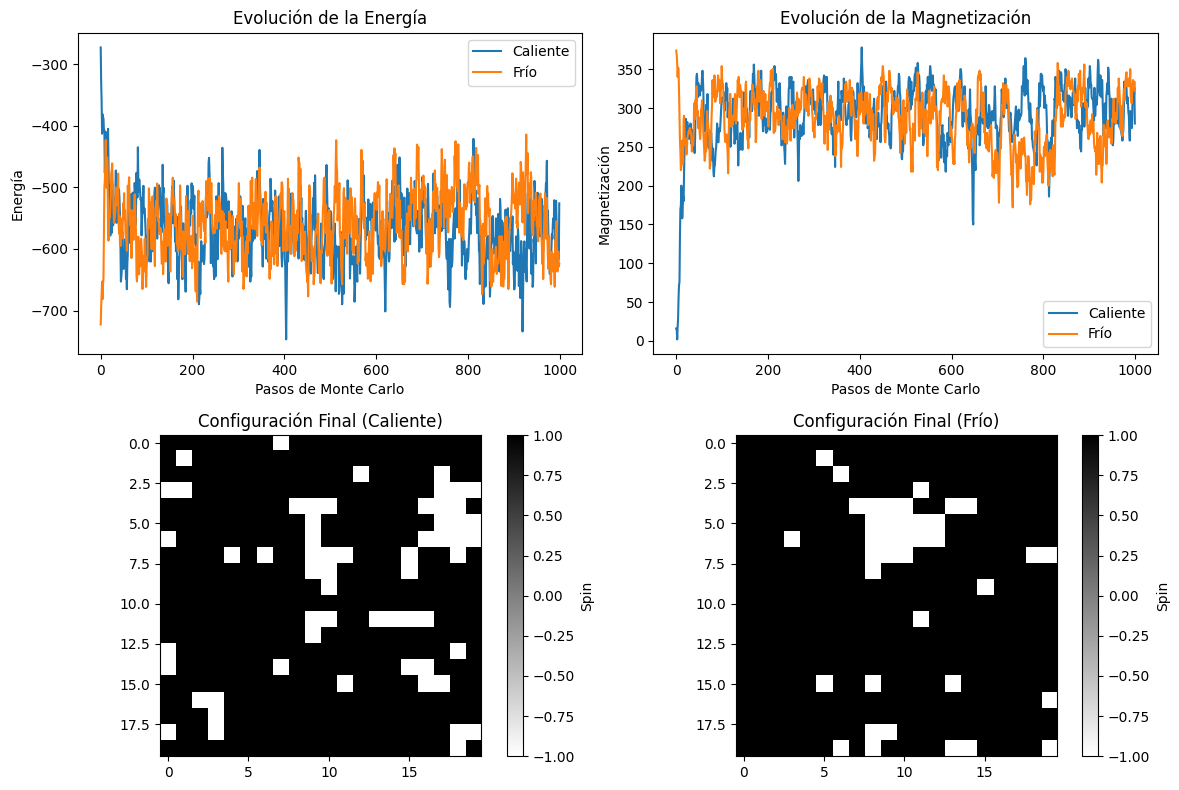

In [2]:
def metropolis_ising(L, H, J, beta, N, inicializacion='caliente'):
    """
    Simula el modelo de Ising utilizando el algoritmo de Metropolis.

    Parámetros:
    L (int): Longitud de la red
    H (float): Intensidad del campo magnético
    J (float): Fuerza de interacción
    beta (float): Temperatura inversa (1/T)
    N (int): Número de pasos de Monte Carlo a realizar
    inicializacion (str): Tipo de inicialización ('frio' o 'caliente')

    Retorna:
    tuple: (energias, magnetizaciones, red_final)
    """
    ### Inicializar la red
    assert inicializacion in ('frio', 'caliente'), \
      "La inicialización debe ser en 'frio' o 'caliente' "

    red = np.ones((L, L)) if inicializacion == 'frio' else \
      np.random.choice([-1, 1], size=(L, L))  # Configuración aleatoria

    ### Variables a devolver
    energias = []
    magnetizaciones = []

    for _ in range(N):
        for _ in range(L*L):  # Un paso de Monte Carlo es L*L intentos de flip
            # Seleccionar un sitio al azar
            i, j = np.random.randint(0, L, 2)

            # Calcular el cambio de energía si se invierte el spin
            vecinos = red[(i+1)%L, j] + red[i, (j+1)%L] + red[(i-1)%L, j] + red[i, (j-1)%L]
            delta_E = 2 * J * red[i, j] * vecinos + 2 * H * red[i, j]

            # Decidir si aceptar o rechazar el cambio
            if delta_E <= 0 or np.random.random() < np.exp(-beta * delta_E):
                red[i, j] *= -1

        # Calcular y almacenar la energía y magnetización después de cada paso de Monte Carlo
        energia = calcular_energia(red, H, J, beta)
        magnetizacion = calcular_magnetizacion(red)
        energias.append(energia)
        magnetizaciones.append(magnetizacion)

    return energias, magnetizaciones, red

# Ejemplo de uso
L = 20  # Tamaño de la red
H = 0.1  # Intensidad del campo magnético
J = 1.0  # Fuerza de interacción
beta = 0.4  # Temperatura inversa
N = 1000  # Número de pasos de Monte Carlo

# Simulación con inicialización caliente
energias_caliente, magnetizaciones_caliente, red_final_caliente = metropolis_ising(L, H, J, beta, N, 'caliente')

# Simulación con inicialización fría
energias_frio, magnetizaciones_frio, red_final_frio = metropolis_ising(L, H, J, beta, N, 'frio')

# Visualización de los resultados
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.plot(energias_caliente, label='Caliente')
plt.plot(energias_frio, label='Frío')
plt.title("Evolución de la Energía")
plt.xlabel("Pasos de Monte Carlo")
plt.ylabel("Energía")
plt.legend()

plt.subplot(222)
plt.plot(magnetizaciones_caliente, label='Caliente')
plt.plot(magnetizaciones_frio, label='Frío')
plt.title("Evolución de la Magnetización")
plt.xlabel("Pasos de Monte Carlo")
plt.ylabel("Magnetización")
plt.legend()

plt.subplot(223)
plt.imshow(red_final_caliente, cmap='binary')
plt.title("Configuración Final (Caliente)")
plt.colorbar(label='Spin')

plt.subplot(224)
plt.imshow(red_final_frio, cmap='binary')
plt.title("Configuración Final (Frío)")
plt.colorbar(label='Spin')

plt.tight_layout()
plt.show()